# Load data

In [1]:
import pandas as pd
import sys
sys.path.append("/Users/anhnd/CodingSpace/Python/PREDKIT")
from constants import NULLABLE_MEASURES
from utils.class_patient import Patients

patients = Patients.loadPatients()
print(patients)
patients.fillMissingMeasureValue(NULLABLE_MEASURES, 0)
print("Ok")

Loading patients... False True
Loading 2
From pkl
Ok


In [2]:
patient0 = patients[0]
print(patient0.measures)

SortedDict({'ag': SortedDict({Timestamp('2119-04-07 23:08:00'): 34.0, Timestamp('2119-04-08 03:42:00'): 22.0, Timestamp('2119-04-08 05:08:00'): 19.0, Timestamp('2119-04-08 10:10:00'): 13.0, Timestamp('2119-04-08 11:25:00'): 15.0, Timestamp('2119-04-08 14:03:00'): 12.0, Timestamp('2119-04-08 16:50:00'): 14.0}), 'age': 64, 'bg': SortedDict({Timestamp('2119-04-07 23:08:00'): 795.0, Timestamp('2119-04-08 03:42:00'): 328.0, Timestamp('2119-04-08 05:08:00'): 224.0, Timestamp('2119-04-08 10:10:00'): 143.0, Timestamp('2119-04-08 14:03:00'): 180.0, Timestamp('2119-04-08 16:50:00'): 150.0}), 'bicarbonate': SortedDict({Timestamp('2119-04-07 23:08:00'): 7.0, Timestamp('2119-04-08 03:42:00'): 12.0, Timestamp('2119-04-08 05:08:00'): 13.0, Timestamp('2119-04-08 10:10:00'): 17.0, Timestamp('2119-04-08 11:25:00'): 16.0, Timestamp('2119-04-08 14:03:00'): 17.0, Timestamp('2119-04-08 16:50:00'): 15.0}), 'bun': SortedDict({Timestamp('2119-04-07 23:08:00'): 73.0, Timestamp('2119-04-08 03:42:00'): 69.0, Time

# Remove missing data

## Remove features with more than 20% missing

In [3]:
# remove measures with less than 80% of data

measures = patients.getMeasures()

for measure, count in measures.items():
    if count < len(patients) * 80 / 100:
        patients.removeMeasures([measure])
        print(measure, count)

pco2 917
ph 954
po2 917
albumin 406
hba1c 326
lymphocyte 446
height 415
urine-ketone 294
crp 19


## Remove patients with more than 20% missing features

In [4]:
patients.removePatientByMissingFeatures()
len(patients)

1206

## Display insight

In [5]:
# dfData = patients.getMeasuresBetween(pd.Timedelta(hours=-6), pd.Timedelta(hours=24), "first")

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(patients.getMeasures())


Counter({'age': 1206,
         'chronic_pulmonary_disease': 1206,
         'ckd_stage': 1206,
         'congestive_heart_failure': 1206,
         'dka_type': 1206,
         'gender': 1206,
         'history_aci': 1206,
         'history_ami': 1206,
         'hypertension': 1206,
         'liver_disease': 1206,
         'macroangiopathy': 1206,
         'malignant_cancer': 1206,
         'mechanical_ventilation': 1206,
         'microangiopathy': 1206,
         'oasis': 1206,
         'preiculos': 1206,
         'race': 1206,
         'saps2': 1206,
         'sofa': 1206,
         'use_NaHCO3': 1206,
         'uti': 1206,
         'ag': 1205,
         'bg': 1205,
         'bicarbonate': 1205,
         'bun': 1205,
         'chloride': 1205,
         'egfr': 1205,
         'hr': 1205,
         'potassium': 1205,
         'scr': 1205,
         'sodium': 1205,
         'dbp': 1204,
         'gcs': 1204,
         'gcs_unable': 1204,
         'rr': 1204,
         'sbp': 1204,
         'calci

In [6]:
akdCount = sum([p.akdPositive for p in patients.patientList])

akdCount / len(patients)

0.39303482587064675

In [7]:
print("Total ", len(patients))
print("AKI ", sum([1 for p in patients if p.akdPositive]))
print("Ratio ", sum([1 for p in patients if p.akdPositive]) / len(patients))

Total  1206
AKI  474
Ratio  0.39303482587064675


# Machine learning

In [8]:
from constants import CATEGORICAL_MEASURES


idColumns = ["subject_id", "hadm_id", "stay_id"]
categoryColumns = CATEGORICAL_MEASURES
labelColumn = "akd"

## Split train-test

In [9]:
splitedPatients = patients.split(5, 27)


def trainTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        yield trainPatients, testPatients


def trainValTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        *trainPatients, valPatients = trainPatients.split(5, 27)
        tmpPatients = Patients(patients=[])
        for trainPatientsElem in trainPatients:
            tmpPatients += trainPatientsElem
        trainPatients = tmpPatients

        yield trainPatients, valPatients, testPatients

## Define model

In [15]:
how = "last"


def createModel(autoProcess=True):
    #from tabpfn import TabPFNClassifier

    #return TabPFNClassifier(device="auto", n_estimators=8)
    from sklearn.neural_network import MLPClassifier
    return MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500)


### fill nan zeros (BEST)

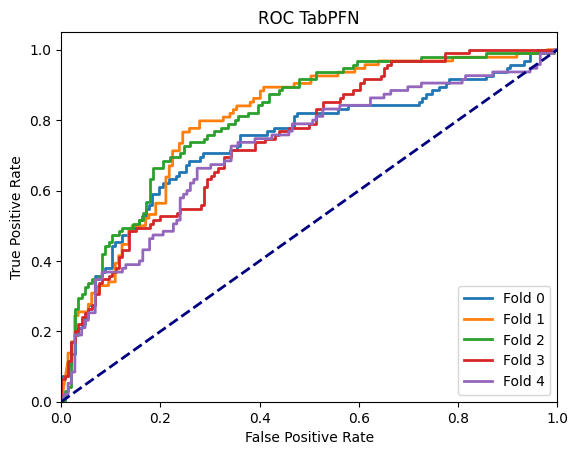

In [16]:
from matplotlib import pyplot as plt
from utils.prepare_data import encodeCategoricalData, trainTestPatients
from utils.class_voter import combineProbas
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc,
)


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
specificity_score_list = []
sensitivity_score_list = []
auc_pr_list = []

models = []

plt.figure()

for i, (trainPatients, testPatients) in enumerate(trainTestPatients(patients)):
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = encodeCategoricalData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    model = createModel()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)

    accuracy_score_list.append(accuracy_score(y_test, y_pred))
    specificity_score_list.append(tn / (tn + fp))
    precision_score_list.append(precision_score(y_test, y_pred))
    recall_score_list.append(recall_score(y_test, y_pred))
    auc_score_list.append(roc_auc_score(y_test, y_pred_proba))
    auc_pr_list.append(auc(recall_vals, precision_vals))

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, lw=2, label=f"Fold {i}")

    # encoder = NormalizeData(encodeNumeric=False)
    # encoder.fit(X_train)
    # mw = ModelWrapper(model, encoder)

    # joblib.dump(mw, TEMP_PATH / f"tabpfn_last_{len(models) - 1}.pkl")

plt.plot([0, 1], [0, 1], linestyle="--", color="navy", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC TabPFN")
plt.legend(loc="lower right")
plt.show()

In [19]:
import numpy as np

print(f"AUC: {np.mean(auc_score_list)} +- {np.std(auc_score_list)}", auc_score_list)
print(f"Accuracy: {np.mean(accuracy_score_list)} +- {np.std(accuracy_score_list)}", accuracy_score_list)
print(f"Specificity: {np.mean(specificity_score_list)} +- {np.std(specificity_score_list)}", specificity_score_list)
print(f"Precision: {np.mean(precision_score_list)} +- {np.std(precision_score_list)}", precision_score_list)
print(f"Recall: {np.mean(recall_score_list)} +- {np.std(recall_score_list)}", recall_score_list)
print(f"AUC PR: {np.mean(auc_pr_list)} +- {np.std(auc_pr_list)}", auc_pr_list)

AUC: 0.7612620029066713 +- 0.0355579730290407 [0.7376297887576083, 0.7998986828774062, 0.806056236481615, 0.7467916366258112, 0.7159336697909157]
Accuracy: 0.7114365076643463 +- 0.014152034726726131 [0.71900826446281, 0.7219917012448133, 0.7261410788381742, 0.7012448132780082, 0.6887966804979253]
Specificity: 0.7747181064206505 +- 0.06592361580951474 [0.8027210884353742, 0.6530612244897959, 0.821917808219178, 0.8356164383561644, 0.7602739726027398]
Precision: 0.6431139959957003 +- 0.02964683143186165 [0.6588235294117647, 0.6046511627906976, 0.6790123456790124, 0.6619718309859155, 0.6111111111111112]
Recall: 0.6143784994400895 +- 0.11300091063797109 [0.5894736842105263, 0.8297872340425532, 0.5789473684210527, 0.49473684210526314, 0.5789473684210527]
AUC PR: 0.6658808463444735 +- 0.028836170047204717 [0.6689882003329704, 0.6993467027843904, 0.6864853293041365, 0.659301262362576, 0.6152827369382942]


In [ ]:
# import shap 


# explainingX = X_test.sample(100)

# explainer = shap.Explainer(model.predict, X_train)
# shape_values = explainer(explainingX)

In [ ]:
# from constants import RESULT_PATH


# shap.summary_plot(shape_values, plot_type="bar", show=False, plot_size=[9, 6])
# plt.savefig(RESULT_PATH / "shap_tabpfn_summary_plot.svg", format="svg")
# plt.show()

In [ ]:
# shap.summary_plot(shape_values, show=False, plot_size=[9, 6])
# plt.savefig(RESULT_PATH / "shap_tabpfn_beeswarm.svg", format="svg")
# plt.show()

In [ ]:
# shap.partial_dependence_plot(
#     "weight",
#     model.predict,
#     explainingX,
#     ice=False,
#     model_expected_value=True,
#     feature_expected_value=True,
# )

In [ ]:
# from lime.lime_tabular import LimeTabularExplainer

# explainer = LimeTabularExplainer(X_train.to_numpy(), mode="classification", feature_names=X_train.columns)

# idx = 14
# exp = explainer.explain_instance(X_test.iloc[idx], model.predict_proba, num_features=10)
# exp.as_list()

In [ ]:
# fig = exp.as_pyplot_figure()

In [ ]:
# print("positive probability", model.predict_proba(X_test.iloc[idx:])[0, 1])
# print("real value", y_test.iloc[idx])

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.colors import ListedColormap
# from tabpfn.scripts.decision_boundary import DecisionBoundaryDisplay


# classifier = model

# # PLOTTING
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111)
# cm = plt.cm.RdBu
# cm_bright = ListedColormap(["#FF0000", "#0000FF"])

# # Plot the training points
# vfunc = np.vectorize(lambda x: np.where(classifier.classes_ == x)[0])
# y_train_index = vfunc(y_train)
# y_train_index = y_train_index == 0

# npX = X_train[["rbc", "wbc"]]
# npX = npX.to_numpy()

# ax.scatter(npX[:, 0], npX[:, 1], c=y_train_index, cmap=cm_bright)

# classifier.fit(npX[:, 0:2], y_train_index)

# DecisionBoundaryDisplay.from_estimator(
#     classifier,
#     npX[:, 0:2],
#     alpha=0.6,
#     ax=ax,
#     eps=2.0,
#     grid_resolution=25,
#     response_method="predict_proba",
# )